### Notebook 2

In [1]:
# Import necessary libraries for spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Used to access spotify api
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [3]:
# Bring in the usual suspects
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [4]:
# Import model from notebook 1
infile = open('pickled_files/df.pickle','rb')
df = pickle.load(infile)
infile.close()
# Set index
df.set_index('id', inplace = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5257 entries, 27gb40S6AIpP5lrhLxlfXj to 0pGQs15pIZFfDyBljcEsjv
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      5257 non-null   float64
 1   energy            5257 non-null   float64
 2   key               5257 non-null   object 
 3   loudness          5257 non-null   float64
 4   mode              5257 non-null   object 
 5   speechiness       5257 non-null   float64
 6   acousticness      5257 non-null   float64
 7   instrumentalness  5257 non-null   float64
 8   liveness          5257 non-null   float64
 9   valence           5257 non-null   float64
 10  tempo             5257 non-null   float64
 11  duration_ms       5257 non-null   float64
 12  time_signature    5257 non-null   object 
 13  genre             5257 non-null   object 
dtypes: float64(10), object(4)
memory usage: 616.1+ KB


In [6]:
# The likelihood of a song having the same exact attributes of another song is extremely low 
# Bye bye duplicate songs
df.duplicated().sum()

94

In [7]:
# Drop in place and keep the first one
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
# Split the columns to easily use later
categorical_columns = list(df.drop('genre', axis = 1).select_dtypes('object').columns)
numerical_columns = list(df.drop('genre', axis = 1).select_dtypes(exclude = 'object').columns)

In [10]:
# Train test split 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['genre'], axis=1),
                                                    df.genre,
                                                   random_state=9)

In [11]:
# See the percentage of each genre in the whole set
y_train.value_counts(normalize=True)

hip-hop      0.411157
alt-metal    0.251291
rock         0.208161
pop          0.129390
Name: genre, dtype: float64

In [12]:
# Function to easily view results
def evaluation_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"F1 Score: {f1_score(y_test, model.predict(X_test), average = 'macro')}")
    plot_confusion_matrix(model, X_test, y_test, cmap='GnBu',xticks_rotation='vertical')

Gonna use f1-score as our metric to compare since the severity of us getting a false negative or a false positive isn't high, but just in general get a great idea of what each genre may be. 

**First Simple Model**

Give us a base model to compare future models to.

In [13]:
lr = LogisticRegression(random_state=9)
ss = StandardScaler()
lr.fit(ss.fit_transform(X_train), y_train)

LogisticRegression(random_state=9)

In [14]:
lr.classes_

array(['alt-metal', 'hip-hop', 'pop', 'rock'], dtype=object)

Training
F1 Score: 0.6357215284786194


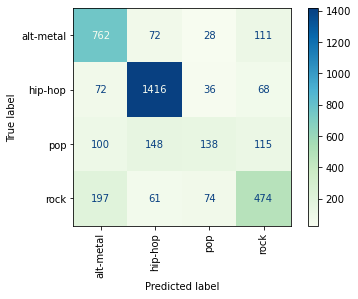

In [15]:
print('Training')
evaluation_report(lr, ss.fit_transform(X_train), y_train)

Testing
F1 Score: 0.6043572246464083


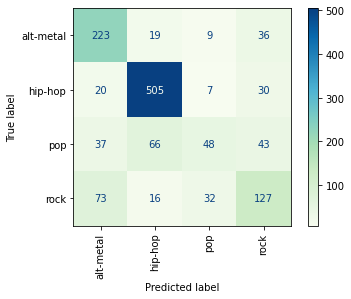

In [16]:
print('Testing')
evaluation_report(lr, ss.transform(X_test), y_test)

Training F1 Score: 0.6357215284786194<br>
Testing F1 Score: 0.6043572246464083<br>

For not addressing the scaling or the class imbalance.. that's pretty good.

In [17]:
# Import imbalanced pipeline since you can't use SMOTE with the regular python pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV

Create pipelines for preprocessing. One for numerical data, one for categorical data and a column transformer to do both.

In [18]:
#Create pipelines
numerical_pipeline = imbpipeline(verbose=False,steps=[
                                ('ss', StandardScaler())
                            ])

categorical_pipeline = imbpipeline(verbose=False,steps=[
                            ('ohe', OneHotEncoder(drop='first',
                                                 sparse=False,))
                            ])

col_trans = ColumnTransformer(verbose=False,transformers=[
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

col_ohe_solo = ColumnTransformer(verbose=False,transformers=[
    ('categorical', categorical_pipeline, categorical_columns)
])


<hl>

For the following models, I gridsearched the edge cases within the cells rather than creating new cells. 

**Second Model**

- Column transform categorical and numerical
- Address the class imbalance through a balanced class weight
- And lets grid search for best params

In [19]:
pipe_log = imbpipeline(verbose=False, steps=[
    ('col_trans', col_trans),
    ('lr', LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced'))
])

param_grid = [
    {
     'lr__penalty' : ['l1','l2'],
     'lr__C' : [.75,.5,.25],
     'lr__solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr = GridSearchCV(pipe_log, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.8s finished


GridSearchCV(estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         ['danceability',
                                                                          'energy',
                                                                          'loudness',
                                                                          'speechiness',
                                                                          'acousticness',
                                                                          'instrumentalness',
                                                                          'liveness',
                                   

In [20]:
gs_lr.best_params_

{'lr__C': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'saga'}

Training
F1 Score: 0.6516991313998259


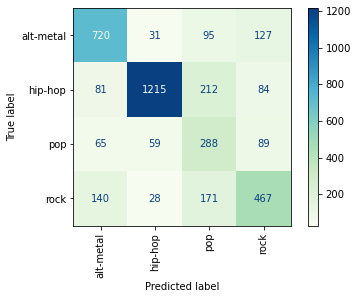

In [21]:
print('Training')
evaluation_report(gs_lr, X_train, y_train)

Testing
F1 Score: 0.6337033152515829


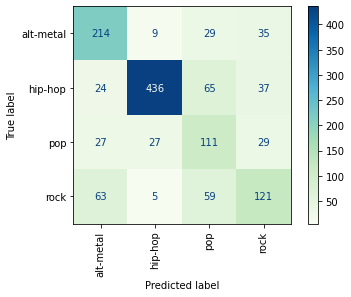

In [22]:
print('Testing')
evaluation_report(gs_lr, X_test, y_test)

Best params : {'lr__C': 0.5, <br>
'lr__penalty': 'l1', <br>
'lr__solver': 'saga'}<br>
Training F1 Score: 0.6516991313998259<br>
Testing F1 Score: 0.6337033152515829<br>

A higher score than our base model and continued low variance. Lets keep going

In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
ohe = OneHotEncoder(drop='first', sparse=False)
sm = SMOTE(random_state = 9)


At this point, I realized something was going wrong when I used the pipelines so in turn, I decided to drop the pipeline and transform the data manually.

In [25]:
categorical_columns

['key', 'mode', 'time_signature']

In [26]:
train_ohe = ohe.fit_transform(X_train[categorical_columns])

In [27]:
len(train_ohe[0])

15

In [28]:
test_ohe = ohe.transform(X_test[categorical_columns])

In [29]:
len(test_ohe[0])

15

In [30]:
train_ohe = X_train[numerical_columns].reset_index().join(pd.DataFrame(train_ohe)).set_index('id')

In [31]:
train_sm = sm.fit_resample(train_ohe, y_train)

In [32]:
test_ohe = X_test[numerical_columns].reset_index().join(pd.DataFrame(test_ohe)).set_index('id')

In [33]:
len(train_ohe.columns)

25

In [34]:
len(pd.get_dummies(X_train, drop_first=True).columns)

25

**Model 3**

Since we have a mixture of categorical and numerical features and a large amount of training samples, lets try XGBoost. Combine that with one hot encoder, smote, and gridsearch and let us see what happens. 

In [35]:
from xgboost import XGBClassifier

In [36]:
#Make sure not to over fit
xgbc = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'max_depth': [1,2],
    'learning_rate': [.1,.05,.01,.005],
    'n_estimators': range(180,220,20),
    'booster': ['gbtree', 'dart']
}
#Run gridsearch
gs_xgbc = GridSearchCV(xgbc, param_grid=params, scoring='f1_macro', n_jobs =-1 )

In [37]:
gs_xgbc.fit(train_sm[0], train_sm[1])

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=9,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=Non

In [38]:
gs_xgbc.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200}

Training
F1 Score: 0.7938831125701951


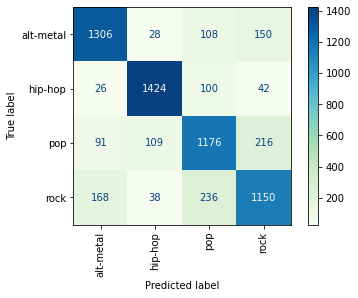

In [39]:
print('Training')
evaluation_report(gs_xgbc, train_sm[0], train_sm[1])

Testing
F1 Score: 0.6747161283690849


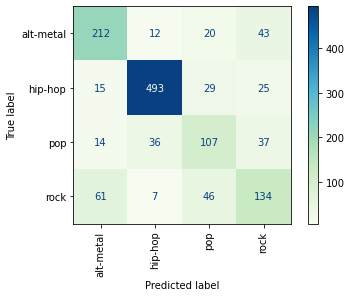

In [40]:
print('Testing')
evaluation_report(gs_xgbc, test_ohe, y_test)

Best Params: {'booster': 'gbtree',<br>
 'learning_rate': 0.1, <br>
 'max_depth': 2,<br>
 'n_estimators': 200}<br>
 
 Training F1 Score: 0.7938831125701951<br>
 Testing F1 Score: 0.6747161283690849<br>

High score, but high variance. Let's try to find a balance.

**Model 4**

Take a quick pivot and try gradient boosting classifier. 

In [41]:
gbclf = GradientBoostingClassifier(random_state = 9)

param_grid = [
    {
     'n_estimators' : [100,125,],
     'learning_rate' : [.15, .2,],
     'max_depth': [1,2,]
    }, 
]

gs_gbclf = GridSearchCV(gbclf, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_gbclf.fit(train_sm[0], train_sm[1])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished


GridSearchCV(estimator=GradientBoostingClassifier(random_state=9), n_jobs=-1,
             param_grid=[{'learning_rate': [0.15, 0.2], 'max_depth': [1, 2],
                          'n_estimators': [100, 125]}],
             scoring='f1_macro', verbose=True)

In [42]:
gs_gbclf.best_params_

{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 125}

Training
F1 Score: 0.8275685801070901


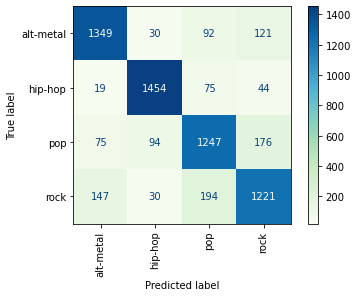

In [43]:
print('Training')
evaluation_report(gs_gbclf, train_sm[0], train_sm[1])

Testing
F1 Score: 0.6836960771292219


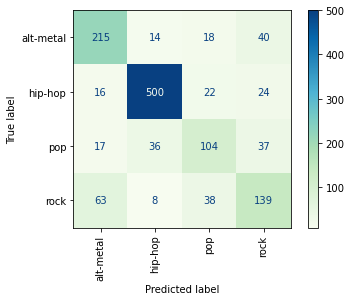

In [44]:
print('Testing')
evaluation_report(gs_gbclf, test_ohe, y_test)

Best Params: {'learning_rate': 0.2,<br>
'max_depth': 2,<br>
'n_estimators': 125}<br>
Training F1 Score: 0.8275685801070901<br>
Testing F1 Score: 0.6836960771292219<br>

Again high score but high variance. It's not the best best yet. 

**Model 5**

Here I wanted to try the logistic regression without the pipeline just to do a quick logic check as well as see if it made a difference. 

In [45]:
lr_col_trans = ColumnTransformer(verbose=False,transformers=[
    ('numerical', numerical_pipeline, numerical_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

lr_train_transf = lr_col_trans.fit_transform(X_train)
lr_test_transf = lr_col_trans.transform(X_test)

In [46]:
lr2 = LogisticRegression(max_iter = 10000, random_state=9, class_weight='balanced')

param_grid = [
    {
     'penalty' : ['l1','l2'],
     'C' : [.75,.5,.25],
     'solver' : ['saga','sag', 'lbfgs']
    }, 
]

gs_lr2 = GridSearchCV(lr2, param_grid = param_grid, 
                        scoring = 'f1_macro', n_jobs=-1, verbose=True)
gs_lr2.fit(lr_train_transf, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.7s finished


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=9),
             n_jobs=-1,
             param_grid=[{'C': [0.75, 0.5, 0.25], 'penalty': ['l1', 'l2'],
                          'solver': ['saga', 'sag', 'lbfgs']}],
             scoring='f1_macro', verbose=True)

In [47]:
gs_lr2.best_params_

{'C': 0.5, 'penalty': 'l1', 'solver': 'saga'}

Training
F1 Score: 0.6516991313998259


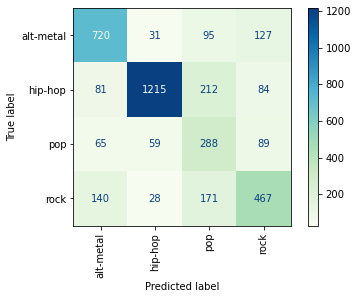

In [48]:
print('Training')
evaluation_report(gs_lr2, lr_train_transf, y_train)

Testing
F1 Score: 0.6337033152515829


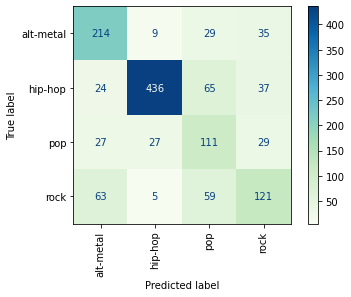

In [49]:
print('Testing')
evaluation_report(gs_lr2, lr_test_transf, y_test)

No difference, same scores as the inital logistic regression

**Model 6**

Try XGBoost with an added class_weight attribute instead of SMOTE to account for the class imbalance. 

In [50]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [51]:
classes_weights

array([0.99486125, 0.99486125, 1.20099256, ..., 1.20099256, 0.6080402 ,
       0.6080402 ])

In [52]:
xgbc2 = XGBClassifier(random_state = 9, n_jobs = -1)
params = {
    'max_depth': [1,2],
    'learning_rate': [.1,.05,.01,.005],
    'n_estimators': range(180,220,20),
    'booster': ['gbtree','dart'],
#     'weight': classes_weights
}
#Run gridsearch
gs_xgbc2 = GridSearchCV(xgbc2, param_grid=params, scoring='f1_macro', n_jobs =-1 )
gs_xgbc2.fit(train_ohe, y_train, sample_weight=classes_weights)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=9,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=Non

In [53]:
gs_xgbc2.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 200}

Training
F1 Score: 0.7540954440819798


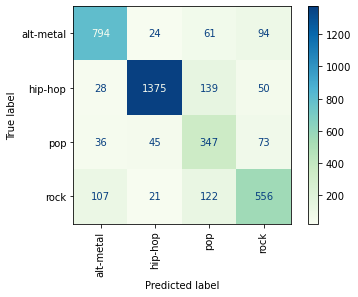

In [54]:
print('Training')
evaluation_report(gs_xgbc2, train_ohe, y_train)

Testing
F1 Score: 0.665158434297283


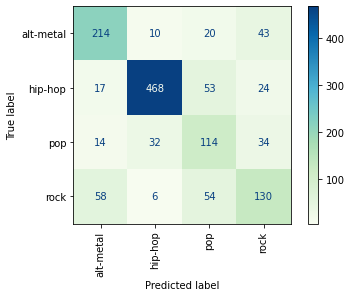

In [55]:
print('Testing')
evaluation_report(gs_xgbc2, test_ohe, y_test)

Best Params: <br>
{'booster': 'gbtree',<br>
 'learning_rate': 0.1,<br>
 'max_depth': 2,<br>
 'n_estimators': 200}<br>

Training
F1 Score: 0.7540954440819798<br>

Testing
F1 Score: 0.665158434297283<br>

**Model 7**

In [56]:
from sklearn.ensemble import VotingClassifier


In [57]:
voting_clf = VotingClassifier(
                estimators=[('xgb', gs_xgbc2.best_estimator_), 
                            ('gbclf', gs_gbclf.best_estimator_)], 
                voting='hard')

voting_clf.fit(train_ohe, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=2, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                    

F1 Score: 0.7646988157032565


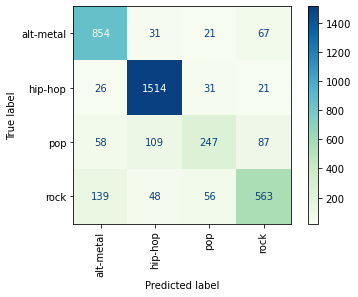

In [58]:
evaluation_report(voting_clf, train_ohe, y_train)

F1 Score: 0.6676704991622819


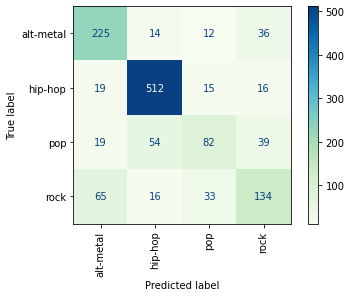

In [59]:
evaluation_report(voting_clf, test_ohe, y_test)

### Pick the best model 

In [60]:
best_model = voting_clf

In [61]:
X_final = df.drop('genre', axis = 1)
y_final = df.genre

In [62]:
# Follow the same transformation on the initial model and do the same to whole dataframe
final_ohe = ohe.transform(X_final[categorical_columns])
final_ohe = X_final[numerical_columns].reset_index().join(pd.DataFrame(final_ohe)).set_index('id')

In [63]:
final_ohe.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,5,6,7,8,9,10,11,12,13,14
id,,,,,,,,,,,,,,,,,,,,,
27gb40S6AIpP5lrhLxlfXj,0.423,0.380,-10.254,0.0262,0.002160,0.83200,0.0957,0.0432,87.029,237333.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6EXwGsQn4r26YHEjRRpch2,0.609,0.655,-7.985,0.5070,0.105000,0.00000,0.0939,0.3160,160.415,208867.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3i6IBKqiI7zke1ilNniYXQ,0.650,0.444,-7.672,0.0359,0.000162,0.16500,0.1110,0.4760,92.246,157280.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4nS1ASybRmUQ5RheSTyD9i,0.504,0.763,-8.714,0.0763,0.692000,0.00766,0.1730,0.9280,140.272,106133.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
65gMVplMNmDkbE6wwsDBD4,0.786,0.811,-7.422,0.2670,0.224000,0.00000,0.3570,0.3560,98.256,278800.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


#### Fit the best model on whole dataset

In [64]:
#Fit best model on whole dataset
best_model.fit(final_ohe, y_final)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=2, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                                    

F1 Score: 0.7511444335222169


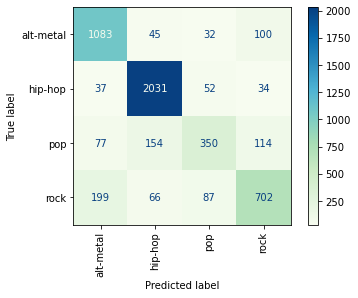

In [65]:
# See how well it does
evaluation_report(best_model, final_ohe, y_final)

Pretty high score for the test score for the set it trained on 

#### See which features are most important in predicting genre

In [66]:
vclf_xgbc = best_model.estimators_[0]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

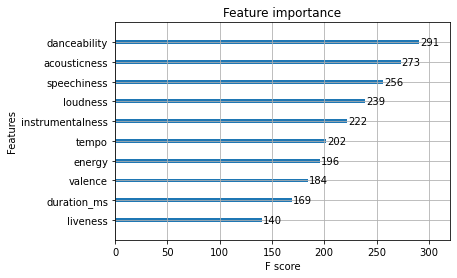

In [67]:
from xgboost import plot_importance
plot_importance(vclf_xgbc, max_num_features=10)

Add unsurprisingly, the features that had clear differences in the EDA are the features that have the most importance. We won't be able to tell the gravitas of each feature or which feature predicts which genre more but cool to see. No surprises.  

In [68]:
vclf_gbc = best_model.estimators_[1]

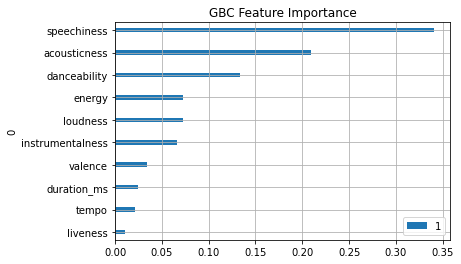

In [78]:
# Plot feature importance from gradient boosting classifier
pd.DataFrame([final_ohe.columns,vclf_gbc.feature_importances_]).T.set_index(0).sort_values(by=1, 
                                                                                           ascending = False)[:10].sort_values(by=1, 
                                                                                                                               ascending = True).plot(kind="barh", width=.2, grid=True,
                                                                                                                                                      title = "GBC Feature Importance");


And with gradient boosting classifier, the feature importance is relatively the same as the XGBoost classifier with few differences but with the GBC, we can see the impact of each feature. 

In [70]:
all_songs = df

#### Modify the dataset with the results

Add the predicted genre as the genre for each song to use in our content based recommender system and drop the intial genre column pulled by the playlist. 

In [71]:
all_songs['predicted_genre'] = best_model.predict(final_ohe)
all_songs.drop(['genre'], axis = 1, inplace = True)

#### Export the model

In [72]:
#Export the best model to be used in the other notebooks.
pickle_out = open('pickled_files/all_songs_genre_predicted.pickle',"wb")
pickle.dump([all_songs, best_model, ohe], pickle_out)
pickle_out.close()

In [73]:
all_songs.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,predicted_genre
id,,,,,,,,,,,,,,
27gb40S6AIpP5lrhLxlfXj,0.423,0.380,0,-10.254,1,0.0262,0.002160,0.83200,0.0957,0.0432,87.029,237333.0,3,alt-metal
6EXwGsQn4r26YHEjRRpch2,0.609,0.655,1,-7.985,0,0.5070,0.105000,0.00000,0.0939,0.3160,160.415,208867.0,4,hip-hop
3i6IBKqiI7zke1ilNniYXQ,0.650,0.444,5,-7.672,1,0.0359,0.000162,0.16500,0.1110,0.4760,92.246,157280.0,4,alt-metal
4nS1ASybRmUQ5RheSTyD9i,0.504,0.763,11,-8.714,0,0.0763,0.692000,0.00766,0.1730,0.9280,140.272,106133.0,4,rock
65gMVplMNmDkbE6wwsDBD4,0.786,0.811,7,-7.422,1,0.2670,0.224000,0.00000,0.3570,0.3560,98.256,278800.0,4,hip-hop
